# Image backbone pre-training

Image backbone pretraining is employed in an attempt to make the whole network ensemble training faster.

## Model creation
First, make the required imports:

In [1]:
import sys
sys.path.append("..")
from multitudinous.utils.model_builder import build_img_pretraining

The image pre-training model is chosen from a pre-defined list which is:
- `resnet50_unet`: vanilla ResNet-50 with 4 input channels
- `se_resnet50_unet`: ResNet-50 with 4 input channels and "Squeeze-and-Excitation" (SE) attention
- `cbam_resnet50_unet`: ResNet-50 with 4 input channels and "Convolutional Block Attention Module" (CBAM) attention

Build the image backbone with the specified configuration. Optionally, you can provide a path to a weights file as the second argument if finetuning.

In [2]:
img_pretrainer = build_img_pretraining('se_resnet50_unet', 4)
print(img_pretrainer)

ResNetUNet(
  (resnet): ResNet(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): SEBottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

## Dataset loading
The dataset to use in this case will be the TUM RGB-D dataset.

First, create the dataset object:

In [3]:
from multitudinous.utils.dataset_builder import build_img_dataset

img_dataset = build_img_dataset('tum_rgbd', '../../data/tum_rgbd')
print(img_dataset.__len__())

798


To iterate the dataset, a `DataLoader` can be used. Create the dataloader and visualize a random sample to verify it is working.

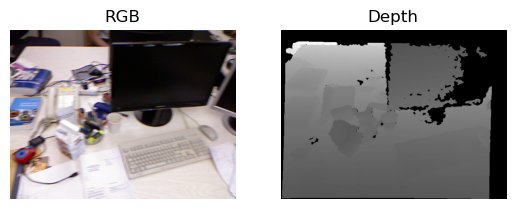

In [4]:
from torch.utils.data import DataLoader

BATCH_SIZE = 1

data_loader = DataLoader(img_dataset, batch_size=BATCH_SIZE, shuffle=True)

# pick the first image from the dataloader
rgb, depth = next(iter(data_loader))

import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.imshow(rgb[0].permute(1, 2, 0))
plt.title('RGB')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(depth[0].squeeze(), cmap='gray')
plt.title('Depth')
plt.axis('off')
plt.show()

## Training loop
The training loop trains the image backbone.

The loss function used is pixel loss. Pixel loss is the normalized Euclidean distance between the output image and the target image.

In [5]:
from multitudinous.utils.loss_fns import pixel_loss # import the pixel loss
import torch

EPOCHS = 10
LEARNING_RATE = 0.001
MOMENTUM = 0.9

# define the optimizer
optimizer = torch.optim.SGD(img_pretrainer.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

# set the model to training mode
img_pretrainer.train()

# set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
img_pretrainer.to(device)

# train the model
for epoch in range(EPOCHS):
    # iterate samples
    for rgb, depth in data_loader:
        # zero the gradients for each batch
        optimizer.zero_grad()

        # build the rgb-d image
        rgb = rgb.to(device)
        depth = depth.to(device)
        depth = depth.unsqueeze(1)

        rgbd = torch.cat((rgb, depth), dim=1)

        # forward pass
        pred_depth = img_pretrainer(rgbd)

        # compute pixel loss
        loss_total = 0
        for i in range(len(pred_depth)):
            loss_total += pixel_loss(pred_depth[i], depth[i])
        loss = loss_total / len(pred_depth)

        # compute gradients
        loss.backward()

        # adjust gradients
        optimizer.step()

        # free memory
        del rgbd, pred_depth

    print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item()}')

    # save the model
    torch.save(img_pretrainer.state_dict(), f'img_pretrainer_epoch_{epoch+1}.pth')


Epoch 1/10, Loss: 0.002165026729926467
Epoch 2/10, Loss: 0.000644625339191407
Epoch 3/10, Loss: 0.0008065958973020315
Epoch 4/10, Loss: 0.0006425786996260285
Epoch 5/10, Loss: 0.001160861924290657
Epoch 6/10, Loss: 0.0004539614892564714
Epoch 7/10, Loss: 0.0003874504764098674
Epoch 8/10, Loss: 0.00044349662493914366


## Experiment the results

Experiment inferencing to visually evaluate the results.

torch.Size([3, 480, 640]) torch.Size([1, 480, 640]) torch.Size([4, 480, 640])


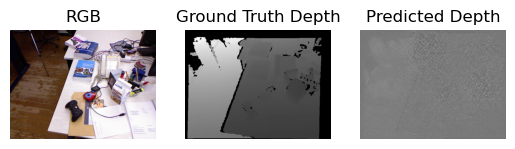

In [ ]:
import torch

# pick the first image from the dataloader
rgb, depth = next(iter(data_loader))

# load the model
img_pretrainer.load_state_dict(torch.load('img_pretrainer_epoch_5.pth'))

# get the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

img_pretrainer.to(device)

# set the model to evaluation mode
img_pretrainer.eval()

# build the rgb-d image
rgb = rgb.to(device)
rgb = rgb.squeeze(0)
depth = depth.to(device)
rgbd = torch.cat((rgb, depth), dim=0)

print(rgb.shape, depth.shape, rgbd.shape)

# forward pass
pred_depth = img_pretrainer(rgbd.unsqueeze(0))

# plot the results
plt.subplot(1, 3, 1)
plt.imshow(rgb.permute(1, 2, 0).cpu())
plt.title('RGB')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(depth.squeeze().cpu(), cmap='gray')
plt.title('Ground Truth Depth')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(pred_depth.squeeze().detach().cpu(), cmap='gray')
plt.title('Predicted Depth')
plt.axis('off')
plt.show()

# free the model memory
del img_pretrainer